In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


Load and clean the data

In [3]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Cheapestelectriccars-EVDatabase.csv'
ev_data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clean price columns

In [4]:
def clean_price_column(column):
    return pd.to_numeric(column.str.replace(r'[^\d.]', '', regex=True), errors='coerce')

ev_data['PriceinGermany'] = clean_price_column(ev_data['PriceinGermany'])
ev_data['PriceinUK'] = clean_price_column(ev_data['PriceinUK'])

Clean performance metric

In [5]:
ev_data['Acceleration'] = pd.to_numeric(ev_data['Acceleration'].str.extract(r'([\d.]+)', expand=False), errors='coerce')
ev_data['TopSpeed'] = pd.to_numeric(ev_data['TopSpeed'].str.extract(r'([\d.]+)', expand=False), errors='coerce')
ev_data['Range'] = pd.to_numeric(ev_data['Range'].str.extract(r'([\d.]+)', expand=False), errors='coerce')

Currency conversion: Convert UK prices to Euros (current rate 1 GBP = 1.17 EUR)

In [6]:
exchange_rate = 1.17
ev_data['PriceinUK_EUR'] = ev_data['PriceinUK'] * exchange_rate

Combine price data for comparison

In [7]:
ev_data['PriceMean'] = ev_data[['PriceinGermany', 'PriceinUK_EUR']].mean(axis=1)

Drop rows with missing prices

In [8]:
ev_data = ev_data.dropna(subset=['PriceMean', 'Acceleration', 'TopSpeed', 'Range'])

Feature selection for ML

In [9]:
features = ['Acceleration', 'TopSpeed', 'Range']
target = 'PriceMean'

X = ev_data[features]
y = ev_data[target]

Split the data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Ml model Linear Regression

In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

Random Forest Regressor

In [12]:
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Evaluation

In [13]:
def evaluate_model(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.2f}")
    return mse, rmse, r2

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Linear Regression Performance:
  RMSE: 21636.82
  R²: 0.64
Random Forest Performance:
  RMSE: 25841.11
  R²: 0.48


(667763103.1901091, 25841.112653872107, 0.48102169011779206)

Visualization: Predictions vs Actual

In [14]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Linear Regression Predictions

Text(0.5, 1.0, 'Linear Regression Predictions')

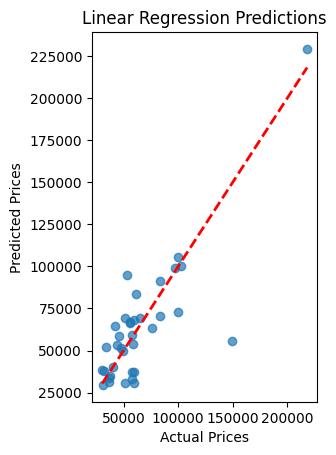

In [15]:
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Linear Regression Predictions")

Random Forest Predictions

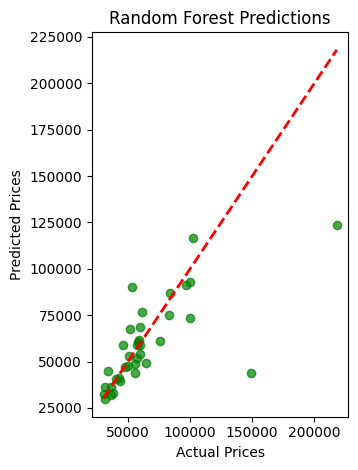

In [16]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Random Forest Predictions")

plt.tight_layout()
plt.show()


Correlation Heatmap (EDA)

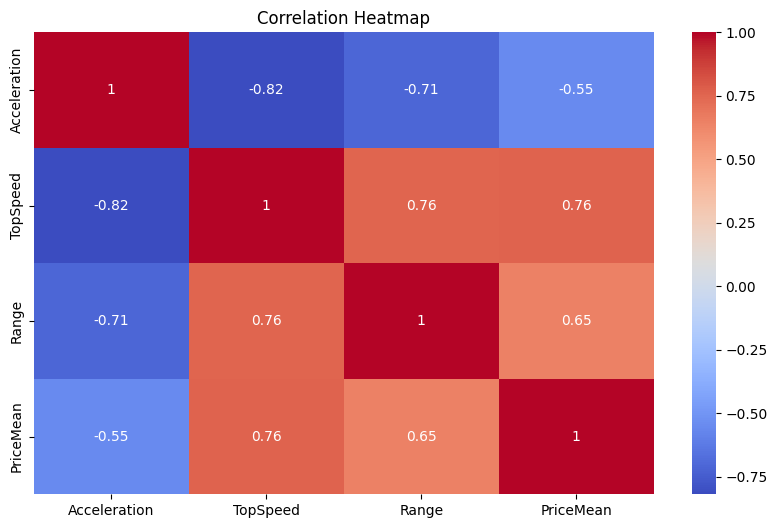

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(ev_data[features + [target]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Filter data for vehicles available in both countries (non-missing prices for Germany and UK)


In [18]:
available_in_both = ev_data.dropna(subset=['PriceinGermany', 'PriceinUK_EUR'])

Calculate average prices for each country

In [19]:
average_price_germany = available_in_both['PriceinGermany'].mean()
average_price_uk = available_in_both['PriceinUK_EUR'].mean()

Prepare data for visualization

In [20]:
price_summary = pd.DataFrame({
    'Country': ['Germany', 'UK (in EUR)'],
    'Average Price (EUR)': [average_price_germany, average_price_uk]
})

Average Prices Bar Chart

<ipython-input-21-946b52d5a730>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=price_summary, x='Country', y='Average Price (EUR)', palette='coolwarm')


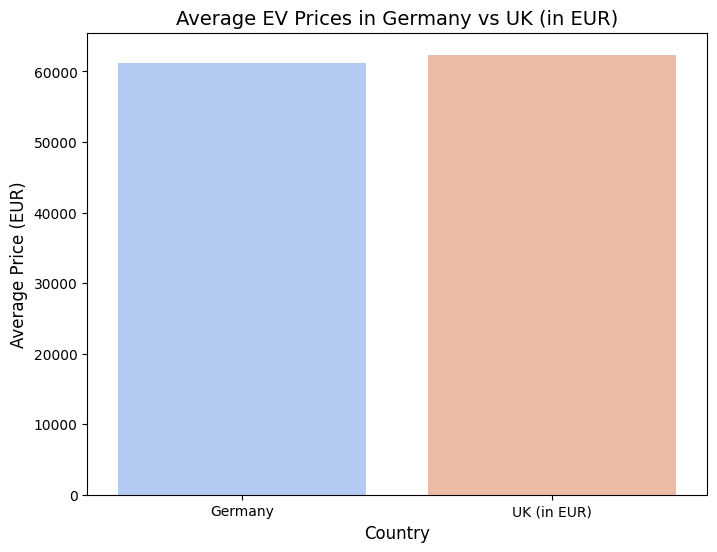

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(data=price_summary, x='Country', y='Average Price (EUR)', palette='coolwarm')
plt.title('Average EV Prices in Germany vs UK (in EUR)', fontsize=14)
plt.ylabel('Average Price (EUR)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

Box Plot: Price Distributions
Reset index for concatenation

In [22]:
germany_prices = available_in_both['PriceinGermany'].reset_index(drop=True)
uk_prices = available_in_both['PriceinUK_EUR'].reset_index(drop=True)

Create country labels for both countries

In [23]:
countries = ['Germany'] * len(germany_prices) + ['UK (in EUR)'] * len(uk_prices)

 Concatenate prices and country labels

In [24]:
prices_combined = pd.concat([germany_prices, uk_prices], axis=0).reset_index(drop=True)
countries_combined = pd.Series(countries)

box plot

<ipython-input-25-597dd1a5752b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=countries_combined, y=prices_combined, palette='coolwarm')


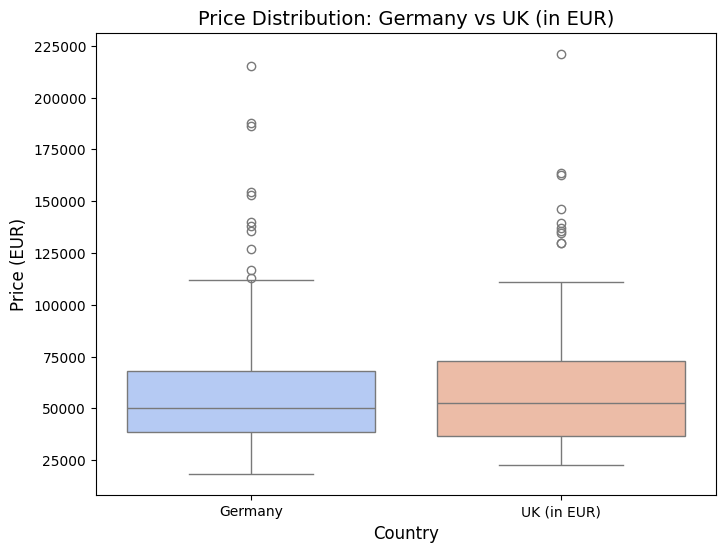

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=countries_combined, y=prices_combined, palette='coolwarm')
plt.title('Price Distribution: Germany vs UK (in EUR)', fontsize=14)
plt.ylabel('Price (EUR)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()